(182, 276)


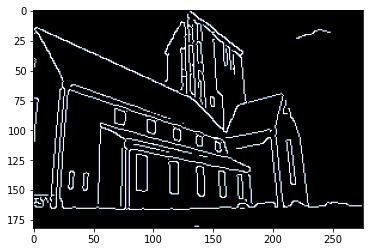

In [5]:
# Importing related libraries
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.image as mpimg
import os

import scipy.misc as sm
import skimage
from skimage.feature import canny
from scipy.ndimage import gaussian_filter
from scipy.ndimage.filters import convolve
from scipy import misc
from scipy import ndimage

# Loading the picture
img = mpimg.imread('image1.jfif')
img = skimage.color.rgb2gray(img)
print(img.shape)

# Defining gaussian Kernel
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

# Defining Sobel Filter
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)
    
# Defininf non max suppression function 
def non_max_suppression(img, D):
  M, N = img.shape
  Z = np.zeros((M,N), dtype=np.int32)
  angle = D * 180. / np.pi
  angle[angle < 0] += 180

  for i in range(1,M-1):
      for j in range(1,N-1):
          try:

              q = 255
              r = 255

              #angle 0
              if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                  q = img[i, j+1]
                  r = img[i, j-1]
              #angle 45
              elif (22.5 <= angle[i,j] < 67.5):
                  q = img[i+1, j-1]
                  r = img[i-1, j+1]
              #angle 90
              elif (67.5 <= angle[i,j] < 112.5):
                  q = img[i+1, j]
                  r = img[i-1, j]
              #angle 135
              elif (112.5 <= angle[i,j] < 157.5):
                  q = img[i-1, j-1]
                  r = img[i+1, j+1]

              if (img[i,j] >= q) and (img[i,j] >= r):
                  Z[i,j] = img[i,j]
              else:
                  Z[i,j] = 0
              
          except IndexError as e:
              pass
  
  return Z
  
# Defining threshold with default values if none is given.
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
   
  highThreshold = img.max() * highThresholdRatio;
  lowThreshold = highThreshold * lowThresholdRatio;
  
  M, N = img.shape
  res = np.zeros((M,N), dtype=np.int32)
  
  weak = np.int32(25)
  strong = np.int32(255)
  
  strong_i, strong_j = np.where(img >= highThreshold)
  zeros_i, zeros_j = np.where(img < lowThreshold)
  
  weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
  
  res[strong_i, strong_j] = strong
  res[weak_i, weak_j] = weak
  
  return (res, weak, strong)

# Defininf hysteresis
def hysteresis(img, weak, strong=255):

  M, N = img.shape  
  
  for i in range(1, M-1):
      for j in range(1, N-1):
          if (img[i,j] == weak):
              try:
                  if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                      or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                      or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                      img[i, j] = strong
                  else:
                      img[i, j] = 0
              except IndexError as e:
                  pass
  
  return img

# Defining the canny detector function
def Canny_detector(img, sigma=1.4, low=0.07, high=0.19):   
  img_filtered = convolve(img, gaussian_kernel(5, sigma= sigma))
  grad, theta = sobel_filters(img_filtered)
  img_nms = non_max_suppression(grad, theta)
  img_thresh, weak, strong = threshold(img_nms, lowThresholdRatio= low, highThresholdRatio= high)
  img_final = hysteresis(img_thresh, weak, strong=strong)
  
  return img_final

# Provide the image and other parameters for the canny detector function
canny_img = Canny_detector(img, sigma = 1.2, low = 0.05, high = 0.2)

# Drawing the detected edges of loaded image
plt.figure()
plt.imshow(canny_img, cmap="bone")
plt.show()